In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

# Add project root to path to import experiment manager
sys.path.append('/home/minhang/mds_project/sc_classification')
from utils.experiment_manager import ExperimentManager

/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_

In [2]:
# --- Configuration ---
# Replace with your actual experiment ID
experiment_id = "20250714_205422_fa_100_random_6dbbde08" 
patient_id = "P01"
# Define the 1-based index range for regularization strengths to inspect
reg_strength_indices_to_check = [12, 13, 14]

# --- Setup ---
experiments_dir = '/home/minhang/mds_project/sc_classification/experiments/'
experiment_manager = ExperimentManager(experiments_dir)
experiment = experiment_manager.load_experiment(experiment_id)

Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250714_205422_fa_100_random_6dbbde08


In [3]:
# --- Load and Prepare Data ---
print(f"Loading data for patient {patient_id} from experiment {experiment_id}...")

# 1. Load classification correctness data to get cell barcodes
correctness_path = experiment.experiment_dir / "models" / "classification" / patient_id / "classification_correctness.csv"
if not correctness_path.exists():
    raise FileNotFoundError(f"Classification correctness file not found at: {correctness_path}")
correctness_df = pd.read_csv(correctness_path, index_col=0)
barcodes_for_classification = correctness_df.index.tolist()

# 2. Load patient-specific coefficients
coef_path = experiment.experiment_dir / "models" / "classification" / patient_id / "coefficients.csv"
if not coef_path.exists():
    raise FileNotFoundError(f"Coefficients file not found at: {coef_path}")
coef_df = pd.read_csv(coef_path, index_col=0)

# 3. Load the transformed AnnData containing X_fa
dr_method = experiment.config.config['dimension_reduction']['method']
n_components = experiment.config.config['dimension_reduction']['n_components']
transformed_adata_path = experiment.experiment_dir / "models" / f"{dr_method}_{n_components}" / "transformed_data.h5ad"
if not transformed_adata_path.exists():
    raise FileNotFoundError(f"Transformed AnnData not found at: {transformed_adata_path}")

transformed_adata = sc.read_h5ad(transformed_adata_path)

Loading data for patient P01 from experiment 20250714_205422_fa_100_random_6dbbde08...


In [6]:
# 4. Create the final patient AnnData object by subsetting with the correct barcodes
adata_patient = transformed_adata[barcodes_for_classification].copy()
print(f"Created patient AnnData with {adata_patient.n_obs} cells for analysis.")

# --- Define Color Palettes ---
positive_class = experiment.config.config['preprocessing'].get('positive_class', 'cancer')
negative_class = experiment.config.config['preprocessing'].get('negative_class', 'normal')

# Palette for the Ground Truth plot
cn_label_palette = {
    positive_class: 'orange',
    negative_class: 'lightgreen'
}

# Palette for the 4-category Classification Status plot
status_palette = {
    f'Correct {positive_class.capitalize()}': 'orange',
    'Correct Normal': 'lightgreen',
    'Incorrect (False Negative)': 'red',
    'Incorrect (False Positive)': 'darkgreen'
}

Created patient AnnData with 759 cells for analysis.



Generating UMAPs based on factors selected by LASSO...
Alpha index 12: Found 31 active factors. Recomputing UMAP.


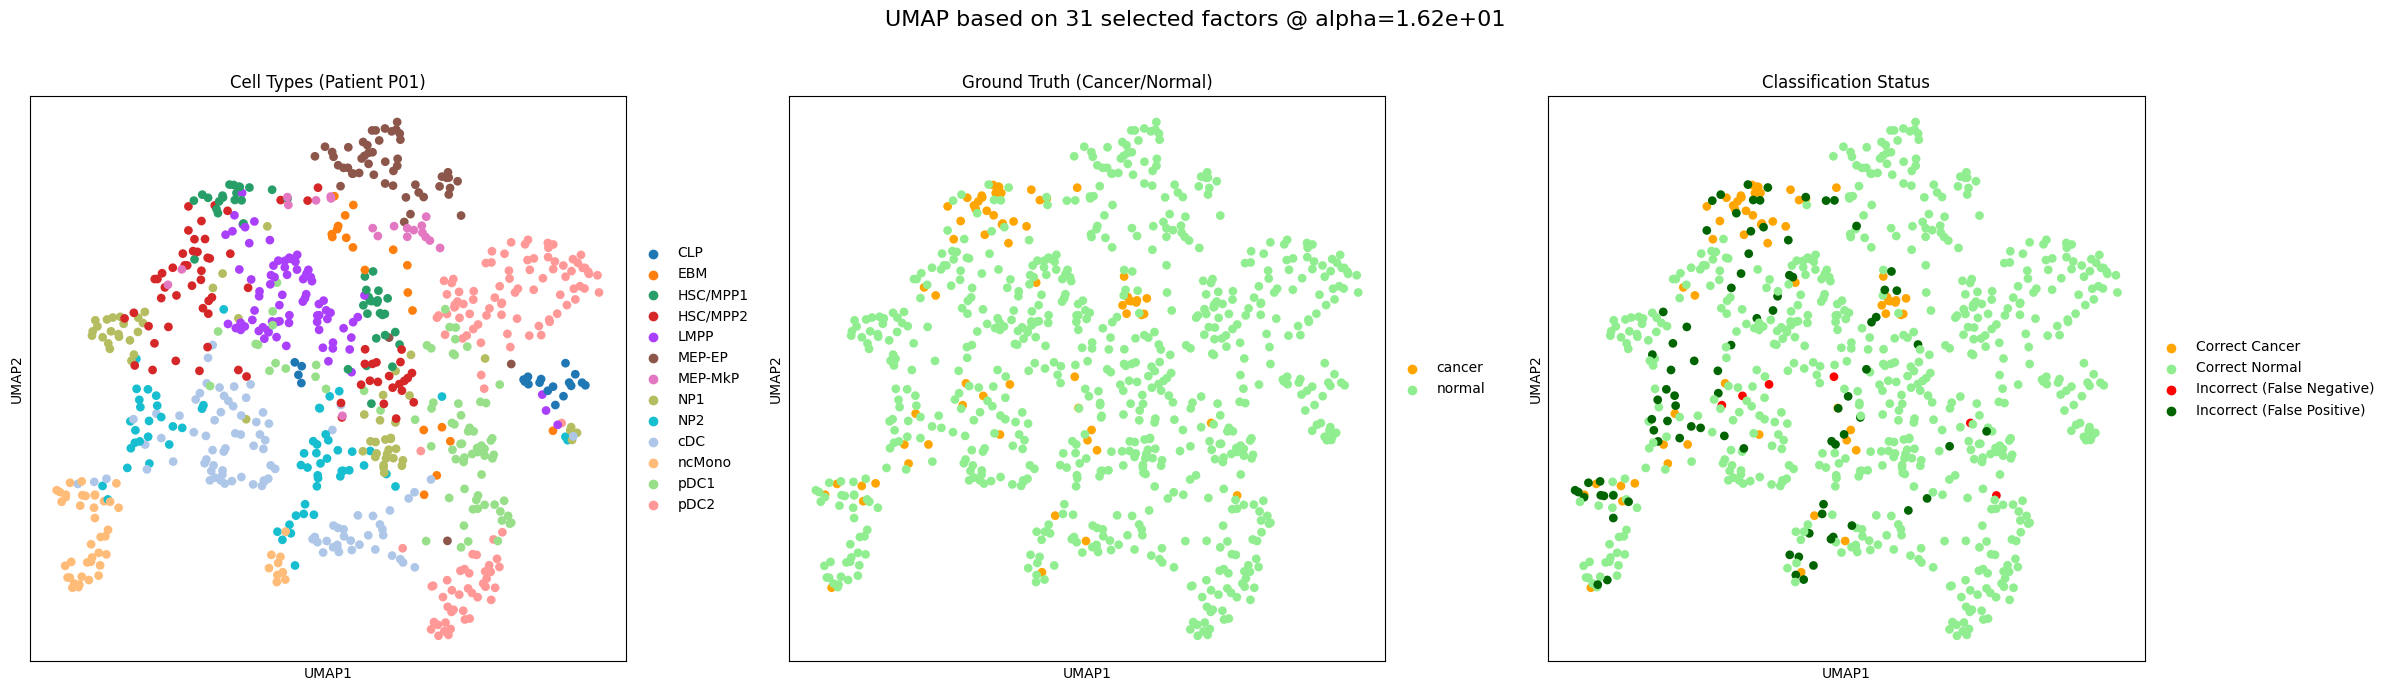

Alpha index 13: Found 13 active factors. Recomputing UMAP.


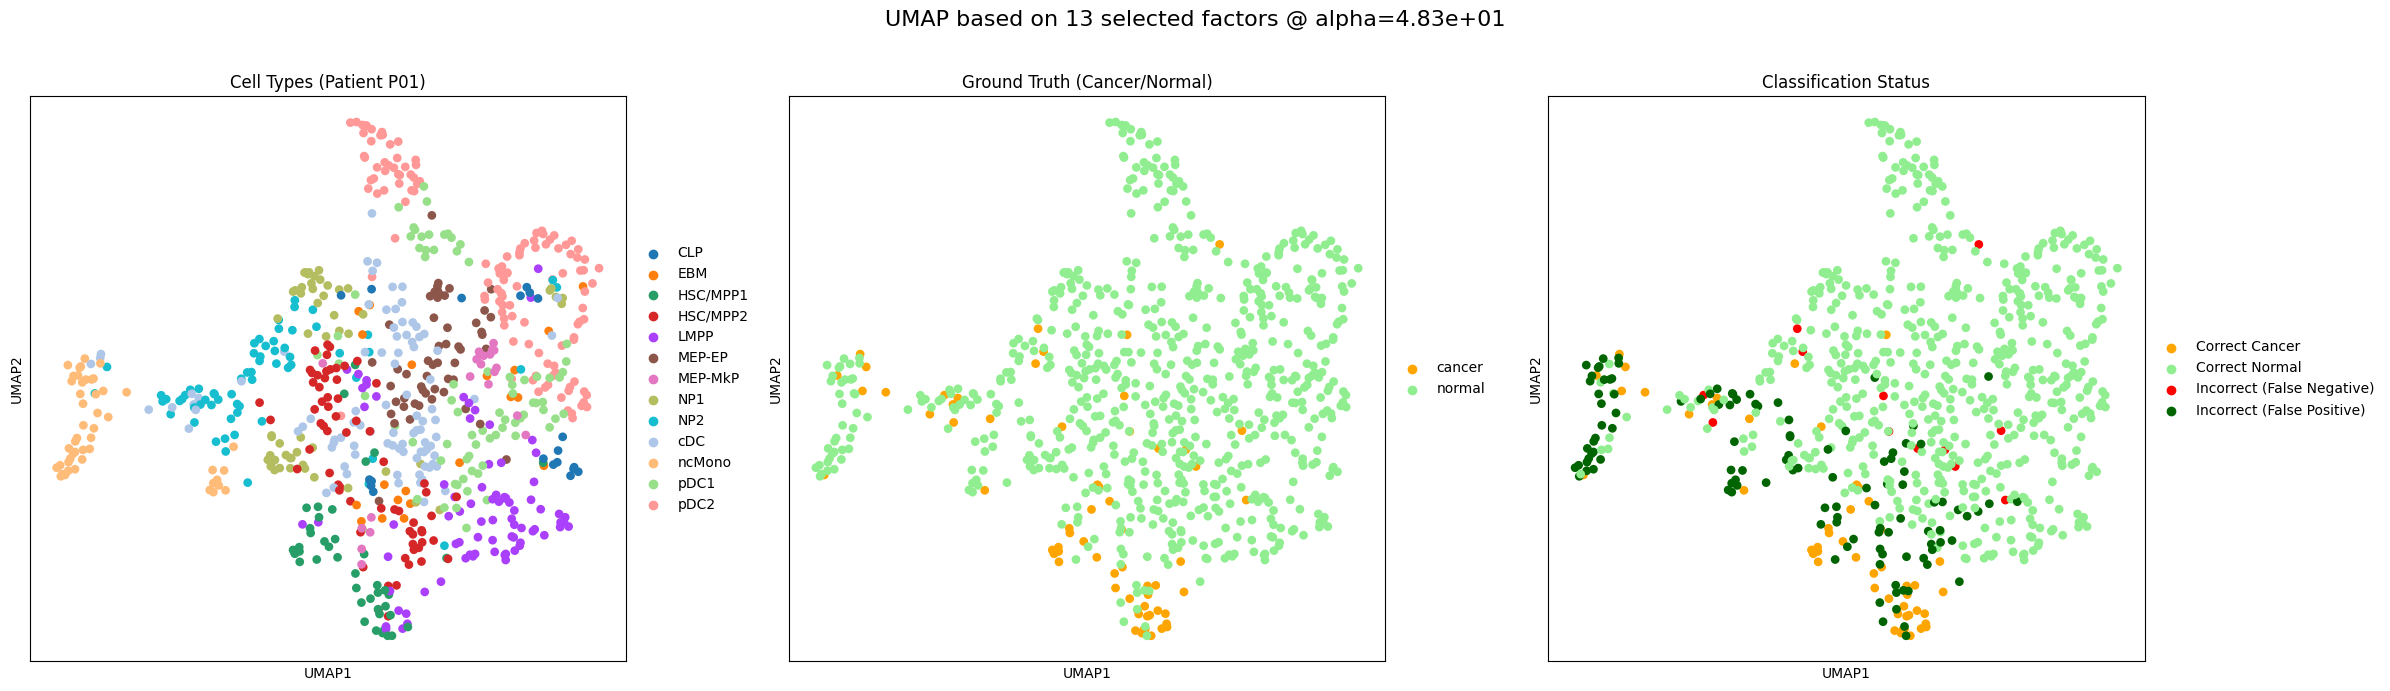

Alpha index 14: Found 3 active factors. Recomputing UMAP.


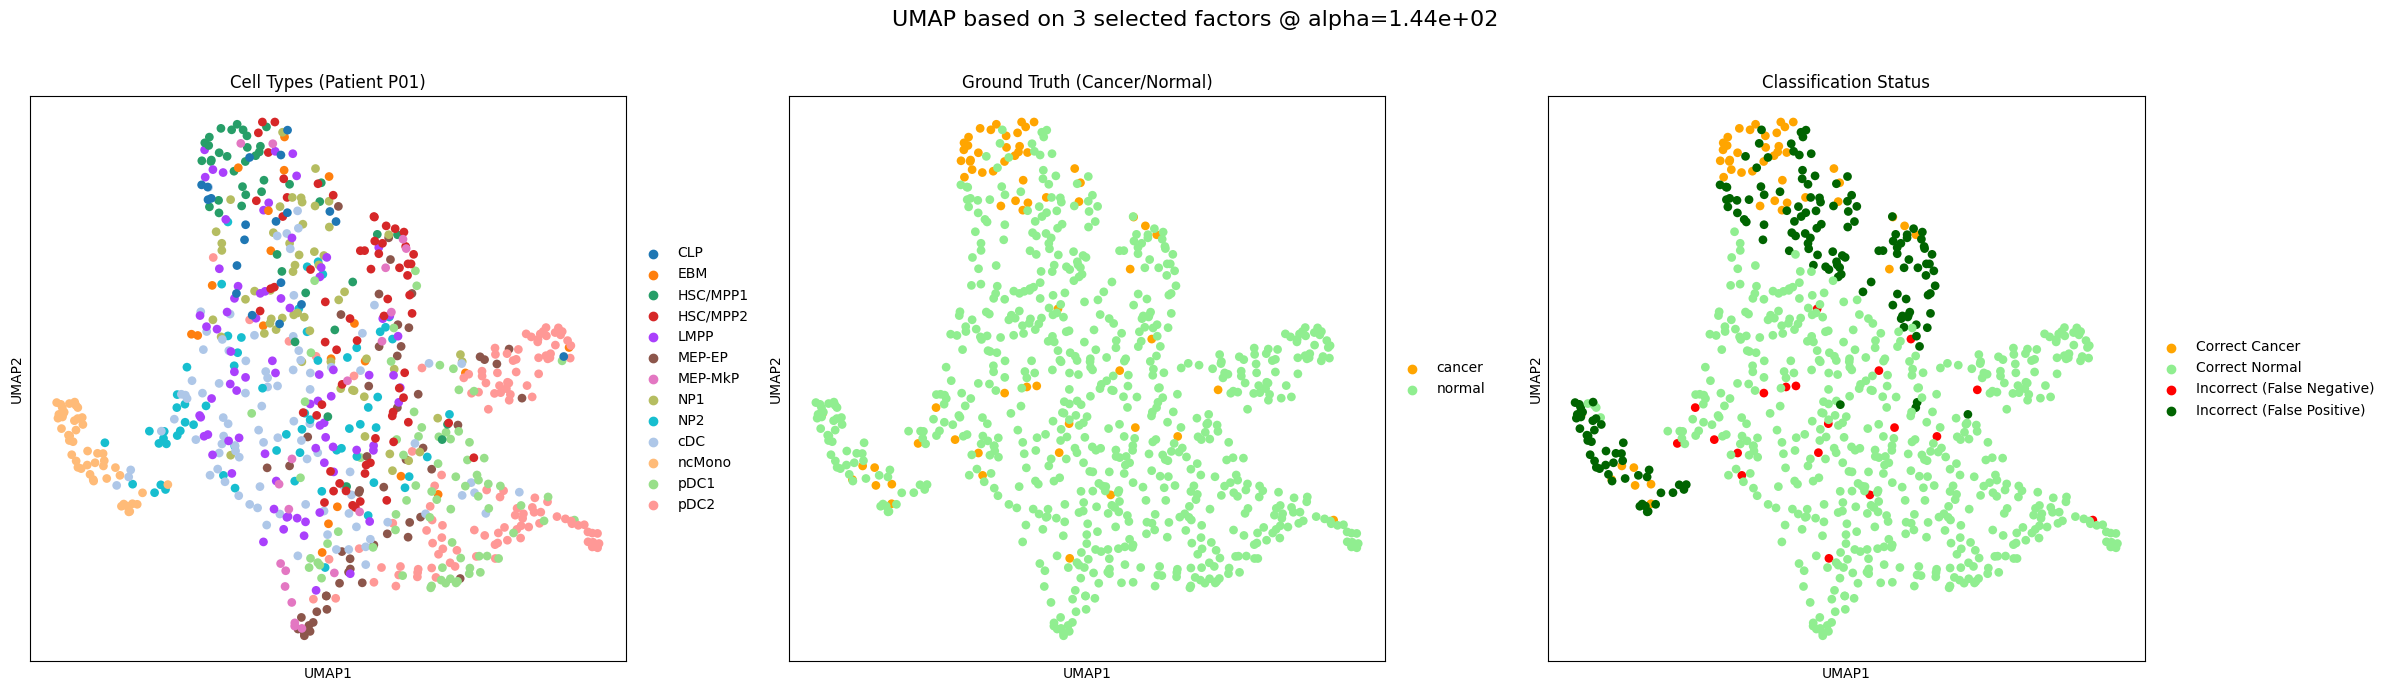

In [7]:
# --- Plotting Loop ---
print("\nGenerating UMAPs based on factors selected by LASSO...")
alpha_indices = [i - 1 for i in reg_strength_indices_to_check] 

for alpha_idx in alpha_indices:
    if alpha_idx >= len(correctness_df.columns):
        print(f"Warning: Index {alpha_idx+1} is out of bounds. Skipping.")
        continue
    
    alpha_col_name = correctness_df.columns[alpha_idx]
    coef_col_name = coef_df.columns[alpha_idx]
    
    # --- Create UMAP based on selected factors for this alpha ---
    # 1. Identify active factors (with non-zero coefficients)
    active_factors_mask = coef_df[coef_col_name] != 0
    n_active_factors = active_factors_mask.sum()
    
    if n_active_factors < 2:
        print(f"Skipping alpha index {alpha_idx+1}: Only {n_active_factors} active factors, need at least 2 for UMAP.")
        continue
        
    print(f"Alpha index {alpha_idx+1}: Found {n_active_factors} active factors. Recomputing UMAP.")
    
    # 2. Create a new data representation using only the active factors
    adata_patient.obsm['X_fa_selected'] = adata_patient.obsm['X_fa'][:, active_factors_mask]
    
    # 3. Compute UMAP on this new representation
    sc.pp.neighbors(adata_patient, use_rep='X_fa_selected', random_state=42)
    sc.tl.umap(adata_patient, min_dist=0.5, spread=1.0, random_state=42)
    
    # --- Create the 4-category classification status ---
    correctness = correctness_df[alpha_col_name]
    ground_truth_labels = adata_patient.obs['CN.label']
    
    conditions = [
        (correctness) & (ground_truth_labels == positive_class),
        (correctness) & (ground_truth_labels != positive_class),
        (~correctness) & (ground_truth_labels == positive_class),
        (~correctness) & (ground_truth_labels != positive_class)
    ]
    choices = [
        f'Correct {positive_class.capitalize()}',
        'Correct Normal',
        'Incorrect (False Negative)',
        'Incorrect (False Positive)'
    ]
    adata_patient.obs['classification_status'] = np.select(conditions, choices, default='Unknown')
    adata_patient.obs['classification_status'] = adata_patient.obs['classification_status'].astype('category')
    
    # Extract alpha value for title
    alpha_val = float(alpha_col_name.split('_')[1])
    
    # --- Generate Plots ---
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    fig.suptitle(f"UMAP based on {n_active_factors} selected factors @ alpha={alpha_val:.2e}", fontsize=16)
    
    # Plot 1: Colored by Predicted Annotation
    sc.pl.umap(
        adata_patient,
        color='predicted.annotation',
        ax=axes[0],
        show=False,
        title=f'Cell Types (Patient {patient_id})'
    )
    
    # Plot 2: Colored by Cancer/Normal Label with new palette
    sc.pl.umap(
        adata_patient,
        color='CN.label',
        palette=cn_label_palette,
        ax=axes[1],
        show=False,
        title=f'Ground Truth (Cancer/Normal)'
    )

    # Plot 3: Colored by the new 4-category Classification Status with new palette
    sc.pl.umap(
        adata_patient,
        color='classification_status',
        palette=status_palette,
        ax=axes[2],
        show=False,
        title=f'Classification Status'
    )
    
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
    plt.show()
